# Preprocessing

### Import necessary modules

In [1]:
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import IsoelectricPoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold

### Read training data

In [2]:
dataCyto=[]
for record in SeqIO.parse("cyto.fasta.txt", "fasta"):
    dataCyto.append(record)
    
dataMito=[]
for record in SeqIO.parse("mito.fasta.txt", "fasta"):
    dataMito.append(record)
    
dataNucleus=[]
for record in SeqIO.parse("nucleus.fasta.txt", "fasta"):
    dataNucleus.append(record)
    
dataSecreted=[]
for record in SeqIO.parse("secreted.fasta.txt", "fasta"):
    dataSecreted.append(record)

print('cyto', len(dataCyto))
print('mito', len(dataMito))
print('nucleus', len(dataNucleus))
print('secreted', len(dataSecreted))

cyto 3004
mito 1299
nucleus 3314
secreted 1605


In [3]:
#example of data
print(dataCyto[0])

ID: sp|Q4JIM5|ABL2_MOUSE
Name: sp|Q4JIM5|ABL2_MOUSE
Description: sp|Q4JIM5|ABL2_MOUSE Abelson tyrosine-protein kinase 2 OS=Mus musculus GN=Abl2 PE=1 SV=1
Number of features: 0
Seq('MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTADAGFNVFTQHDH...VQR', SingleLetterAlphabet())


### Analyse the data to get features

In [4]:
analysed=[]
for i in range(len(dataCyto)):
    analysed_seq=ProteinAnalysis(str(dataCyto[i].seq))
    analysed.append(analysed_seq)
    
for i in range(len(dataMito)):
    analysed_seq=ProteinAnalysis(str(dataMito[i].seq))
    analysed.append(analysed_seq)
    
for i in range(len(dataNucleus)):
    analysed_seq=ProteinAnalysis(str(dataNucleus[i].seq))
    analysed.append(analysed_seq)
    
for i in range(len(dataSecreted)):
    analysed_seq=ProteinAnalysis(str(dataSecreted[i].seq))
    analysed.append(analysed_seq)
print(len(analysed))   

9222


In [5]:
#example of analysed data
print('length:', analysed[0].length)
print('aminoacids',analysed[0].count_amino_acids())
print('aminoacid percent',analysed[0].amino_acids_percent)
print('molecular weight',analysed[0].molecular_weight())

length: 1182
aminoacids {'A': 97, 'C': 17, 'D': 51, 'E': 81, 'F': 35, 'G': 96, 'H': 26, 'I': 30, 'K': 72, 'L': 99, 'M': 22, 'N': 40, 'P': 96, 'Q': 44, 'R': 63, 'S': 118, 'T': 73, 'V': 77, 'W': 13, 'Y': 32}
aminoacid percent None
molecular weight 128194.98120000077


### Features

In [8]:
noOfExamples=len(dataCyto)+len(dataMito)+len(dataNucleus)+len(dataSecreted)
composition=np.zeros((noOfExamples, 20))
for i in range(len(analysed)):
    dict=analysed[i].get_amino_acids_percent()
    for pos,aa in enumerate(dict.values()):
        composition[i,pos]=aa

In [9]:
length=np.zeros((noOfExamples, 1))
for i in range(len(analysed)):
    length[i,0]=analysed[i].length

iep=np.zeros((len(analysed), 1))
for i in range(len(analysed)):
    iep[i,0]=analysed[i].isoelectric_point()

noOfFeatures=22
features=np.zeros((noOfExamples,noOfFeatures))
features=np.append(np.append(composition, length,axis=1),iep, axis=1)



### Labels

In [10]:
#labels for each dataset
labels=np.zeros(noOfExamples)

labels[0:len(dataCyto)]=1
labels[len(dataCyto):len(dataCyto)+len(dataMito)]=2
labels[len(dataCyto)+len(dataMito):len(dataCyto)+len(dataMito)+len(dataNucleus)]=3
labels[len(dataCyto)+len(dataMito)+len(dataNucleus):]=4

In [11]:
enc=OneHotEncoder(labels)
enc.categories

array([1., 1., 1., ..., 4., 4., 4.])

# Model exploration

### Comparing results for different models and for different datasets

In [12]:
model2=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model2.fit(composition, enc.categories)
print('NuSVC trained on composition, score:', model2.score(composition, enc.categories))

NuSVC trained on composition, score: 0.7006072435480373


In [14]:
#grid search for best parameter:
indexes=np.arange(0.1,0.52,0.02)
exploreScores=np.zeros(len(indexes))
for i,nu in enumerate(indexes):
    modelx=svm.NuSVC(nu=nu, decision_function_shape='ovo', probability=True)
    modelx.fit(composition, enc.categories)
    exploreScores[i]=modelx.score(composition, enc.categories)


In [18]:
print(exploreScores)
print('bestScore:',np.max(exploreScores))
print(np.argmax(exploreScores))
best=indexes[int(np.argmax(exploreScores))]
print('best parameter:',best)

[0.87063544 0.88928649 0.88646714 0.88874431 0.89058773 0.88147907
 0.88147907 0.87020169 0.86109304 0.84829755 0.83506831 0.81967035
 0.80676643 0.79191065 0.77792236 0.76718716 0.75287356 0.74213836
 0.7279332  0.71437866 0.70060724]
bestScore: 0.8905877250054218
4
best parameter: 0.18000000000000002


In [19]:
#best nu=0.18
model=svm.NuSVC(nu=np.round(best,2), decision_function_shape='ovo', probability=True)
model.fit(composition, enc.categories)
print('NuSVC trained on composition with best parameter, score:', model.score(composition, enc.categories))

NuSVC trained on composition with best parameter, score: 0.8905877250054218


In [21]:
model3=svm.SVC(decision_function_shape='ovo', probability=True)
model3.fit(composition, enc.categories)
print('SVC trained on composition, score:', model3.score(composition, enc.categories))

SVC trained on composition, score: 0.6477987421383647


In [23]:
model8=svm.SVC(decision_function_shape='ovo', probability=True)
model8.fit(length, enc.categories)
print('SVC trained on sequence length, score:', model8.score(length, enc.categories))

SVC trained on sequence length, score: 0.43103448275862066


In [24]:
model9=svm.SVC(decision_function_shape='ovo', probability=True)
model9.fit(iep, enc.categories)
print('SVC trained on isoelectric point, score:', model9.score(iep, enc.categories))

SVC trained on isoelectric point, score: 0.405985686402082


In [25]:
model4=svm.SVC(decision_function_shape='ovo', probability=True)
model4.fit(features, enc.categories)
print('SVC trained on all features, score:', model4.score(features, enc.categories))

SVC trained on all features, score: 0.4313597918022121


In [26]:
model10=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model10.fit(length, enc.categories)
print('NuSVC trained on sequence length, score:', model10.score(length, enc.categories))

NuSVC trained on sequence length, score: 0.2852960312296682


In [27]:
model11=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model11.fit(iep, enc.categories)
print('NuSVC trained on isoelectric point, score:', model11.score(iep, enc.categories))

NuSVC trained on isoelectric point, score: 0.27521145087833443


In [28]:
model5=svm.NuSVC(nu=0.5, decision_function_shape='ovo', probability=True)
model5.fit(features, enc.categories)
print('NuSVC trained on features, score:', model5.score(features, enc.categories))

NuSVC trained on features, score: 0.4097809585773151


In [29]:
#one classifier per class
model6 = OneVsRestClassifier(model).fit(composition, enc.categories)
print('OneVsRestClassifier trained on all model1, score:', model6.score(composition, enc.categories))

OneVsRestClassifier trained on all model1, score: 0.900455432661028


In [30]:
#best models: model and model6
print('model parameters:',)
model.get_params()

model parameters:


{'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.18,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [31]:
print('model6 parameters:',)
model6.get_params()

model6 parameters:


{'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovo',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__nu': 0.18,
 'estimator__probability': True,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
       max_iter=-1, nu=0.18, probability=True, random_state=None, shrinking=True,
       tol=0.001, verbose=False),
 'n_jobs': None}

### Cross validation

In [32]:
predsTrain1=model.predict(composition)
corrTrain1=np.corrcoef(predsTrain1, enc.categories)
print(corrTrain1[1,0])

predsTrain6=model6.predict(composition)
corrTrain6=np.corrcoef(predsTrain6, enc.categories)
print(corrTrain6[1,0])


0.832542853890028
0.8541007112512605


In [33]:
def KF_svc(X,y,cost=1.0,gamma='scale',k=10):
    kf = KFold(n_splits=k, shuffle=True)
    model_scores=np.zeros(k)
    corr=np.zeros(k)
    #iterator
    it=iter(np.arange(k))
    
    model=svm.SVC(C=cost, kernel='rbf', gamma=gamma, probability=True)
    for train_index, test_index in kf.split(X, y):
        #split the dataset into two parts: (k-1)/k*n and (1/k)*n
        i=next(it)
        print('iteration', i)
        
        #split data
        X_train, X_test=X[train_index], X[test_index]
        y_train, y_test=y[train_index], y[test_index]
        #fit model
        model.fit(X_train, y_train)
        model_scores[i]=model.score(X_test,y_test)
        pred=model.predict(X_test)
        corr[i]=np.corrcoef(pred, y_test)[1,0]
        
    return model, model_scores, corr

In [34]:
model7, score7, corr7=KF_svc(composition, enc.categories);

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [63]:
for i in range(10):
    print(i, 'score:', np.round(score7[i],3), 'correlation:', np.round(corr7[i],3))
print('average score:', np.mean(score7))

0 score: 0.598 correlation: 0.405
1 score: 0.616 correlation: 0.441
2 score: 0.645 correlation: 0.478
3 score: 0.612 correlation: 0.429
4 score: 0.603 correlation: 0.445
5 score: 0.613 correlation: 0.454
6 score: 0.614 correlation: 0.463
7 score: 0.6 correlation: 0.404
8 score: 0.599 correlation: 0.425
9 score: 0.604 correlation: 0.477
average score: 0.6103888809244588


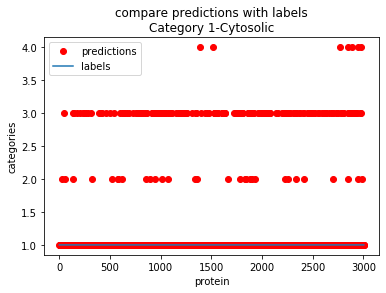

<Figure size 2160x720 with 0 Axes>

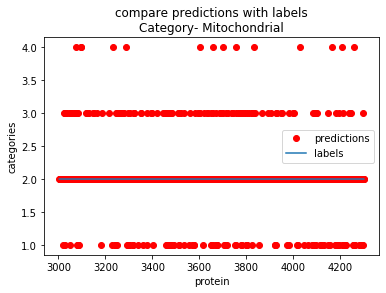

<Figure size 2160x720 with 0 Axes>

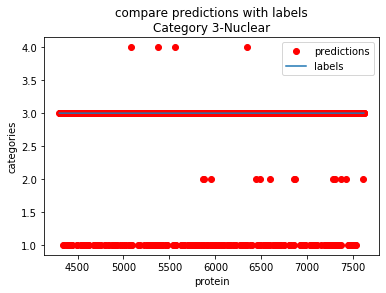

<Figure size 2160x720 with 0 Axes>

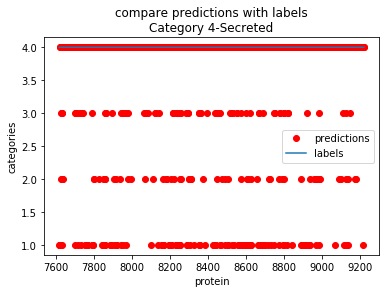

<Figure size 2160x720 with 0 Axes>

In [36]:
predictions=model6.predict(composition)
x=np.arange(len(dataCyto))
y1=predictions[0:len(dataCyto)]
y2=enc.categories[0:len(dataCyto)]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory 1-Cytosolic')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()

x=np.arange(len(dataCyto),len(dataCyto)+len(dataMito))
y1=predictions[len(dataCyto):len(dataCyto)+len(dataMito)]
y2=enc.categories[len(dataCyto):len(dataCyto)+len(dataMito)]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory- Mitochondrial')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()

x=np.arange(len(dataCyto)+len(dataMito),len(dataCyto)+len(dataMito)+len(dataNucleus))
y1=predictions[len(dataCyto)+len(dataMito):len(dataCyto)+len(dataMito)+len(dataNucleus)]
y2=enc.categories[len(dataCyto)+len(dataMito):len(dataCyto)+len(dataMito)+len(dataNucleus)]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory 3-Nuclear')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()

x=np.arange(len(dataCyto)+len(dataMito)+len(dataNucleus), 9222)
y1=predictions[len(dataCyto)+len(dataMito)+len(dataNucleus):]
y2=enc.categories[len(dataCyto)+len(dataMito)+len(dataNucleus):]
x1=x
x2=x
plt.plot(x1, y1, 'ro',label = "predictions")
plt.plot(x2, y2, label = "labels")
plt.xlabel('protein')
plt.ylabel('categories')
plt.title('compare predictions with labels\nCategory 4-Secreted')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()



# Testing

## Make some predictions

In [37]:
print('model 1:')
print('prediction:', model.predict([composition[0]]))
print('probClass1, probClass2, probClass3, probClass 4')
print(model.predict_proba([composition[0]]))
print('\nmodel 6:')
print('prediction:', model6.predict([composition[0]]))
print('probClass1, probClass2, probClass3, probClass 4')
print(model6.predict_proba([composition[0]]))

model 1:
prediction: [1.]
probClass1, probClass2, probClass3, probClass 4
[[0.47573313 0.06059086 0.43156207 0.03211394]]

model 6:
prediction: [1.]
probClass1, probClass2, probClass3, probClass 4
[[0.47856621 0.06723976 0.42910821 0.02508583]]


## Analyse test data

In [38]:
dataBlind=[]
for record in SeqIO.parse("blind.fasta.txt", "fasta"):
    dataBlind.append(record)
print('blind:', len(dataBlind))

blind: 20


In [39]:
blind=[]
for i in range(len(dataBlind)):
    analysed_seq=ProteinAnalysis(str(dataBlind[i].seq))
    blind.append(analysed_seq)

In [40]:
compBlind=np.zeros((len(dataBlind), 20))
for i in range(len(dataBlind)):
    dict=blind[i].get_amino_acids_percent()
    for pos,aa in enumerate(dict.values()):
        compBlind[i,pos]=aa

## Calculcate predictions for NuSVC model

In [41]:

preds=np.zeros(len(dataBlind))
for i in range(len(dataBlind)):
    preds[i]=model.predict([compBlind[i]])
    
probs=np.zeros((len(dataBlind), 4))
for i in range(len(dataBlind)):
    probs[i]=model.predict_proba([compBlind[i]])
    
predProbs=np.array(np.argmax(probs, axis=1)+1)

In [42]:
predProbs

array([3, 4, 4, 1, 4, 3, 1, 1, 1, 2, 2, 3, 4, 4, 3, 3, 4, 3, 2, 1])

In [43]:
print("Predictions for SVC model")
for i in range(len(dataBlind)):
    if preds[i]==predProbs[i]:
        print('index:', i, 'prediction:', preds[i])
    else:
        print('index:',i, 'predicts:', preds[i], 'from probability:', predProbs[i], probs[i, int(predProbs[i]-1)])

Predictions for SVC model
index: 0 prediction: 3.0
index: 1 prediction: 4.0
index: 2 prediction: 4.0
index: 3 prediction: 1.0
index: 4 prediction: 4.0
index: 5 predicts: 1.0 from probability: 3 0.4786159426388875
index: 6 predicts: 2.0 from probability: 1 0.3670000900462888
index: 7 prediction: 1.0
index: 8 prediction: 1.0
index: 9 prediction: 2.0
index: 10 prediction: 2.0
index: 11 predicts: 1.0 from probability: 3 0.41941978019692416
index: 12 prediction: 4.0
index: 13 predicts: 1.0 from probability: 4 0.35165720216602425
index: 14 prediction: 3.0
index: 15 prediction: 3.0
index: 16 prediction: 4.0
index: 17 prediction: 3.0
index: 18 prediction: 2.0
index: 19 prediction: 1.0


In [44]:
for i in range(len(dataBlind)):
    if preds[i]==1:
        print(dataBlind[i].name, 'Cytosolic, Confidence', np.round(np.max(probs[i])*100), '%')
    elif preds[i]==2:
        print(dataBlind[i].name, 'Mitochondrial, Confidence', np.round(np.max(probs[i])*100), '%')
    elif preds[i]==3:
        print(dataBlind[i].name, 'Nuclear, Confidence', np.round(np.max(probs[i])*100), '%')
    elif preds[i]==4:
        print(dataBlind[i].name, 'Secreted, Confidence', np.round(np.max(probs[i])*100), '%')
        

SEQ677 Nuclear, Confidence 35.0 %
SEQ231 Secreted, Confidence 73.0 %
SEQ871 Secreted, Confidence 59.0 %
SEQ388 Cytosolic, Confidence 32.0 %
SEQ122 Secreted, Confidence 76.0 %
SEQ758 Cytosolic, Confidence 48.0 %
SEQ333 Mitochondrial, Confidence 37.0 %
SEQ937 Cytosolic, Confidence 55.0 %
SEQ351 Cytosolic, Confidence 39.0 %
SEQ202 Mitochondrial, Confidence 40.0 %
SEQ608 Mitochondrial, Confidence 41.0 %
SEQ402 Cytosolic, Confidence 42.0 %
SEQ433 Secreted, Confidence 99.0 %
SEQ821 Cytosolic, Confidence 35.0 %
SEQ322 Nuclear, Confidence 61.0 %
SEQ982 Nuclear, Confidence 78.0 %
SEQ951 Secreted, Confidence 35.0 %
SEQ173 Nuclear, Confidence 49.0 %
SEQ862 Mitochondrial, Confidence 33.0 %
SEQ224 Cytosolic, Confidence 58.0 %


## Calculcate predictions for combined model

In [45]:
preds6=np.zeros(len(dataBlind))
for i in range(len(dataBlind)):
    preds6[i]=model6.predict([compBlind[i]])
    
probs6=np.zeros((len(dataBlind), 4))
for i in range(len(dataBlind)):
    probs6[i]=model6.predict_proba([compBlind[i]])
    
predProbs6=np.array(np.argmax(probs6, axis=1)+1)

In [46]:
print("Predictions for combined model")
for i in range(len(dataBlind)):
    if preds6[i]==predProbs6[i]:
        print('index:', i, 'prediction:', preds6[i])
    else:
        print('index:',i, 'predicts:', preds6[i], 'from probability:', predProbs6[i], probs6[i,int(predProbs6[i]-1)])
        

Predictions for combined model
index: 0 prediction: 3.0
index: 1 predicts: 1.0 from probability: 4 0.463294258496682
index: 2 prediction: 1.0
index: 3 prediction: 3.0
index: 4 predicts: 3.0 from probability: 4 0.47168230455534177
index: 5 prediction: 3.0
index: 6 prediction: 2.0
index: 7 prediction: 1.0
index: 8 prediction: 3.0
index: 9 prediction: 2.0
index: 10 prediction: 2.0
index: 11 prediction: 3.0
index: 12 prediction: 4.0
index: 13 predicts: 1.0 from probability: 3 0.4019197541223024
index: 14 prediction: 3.0
index: 15 prediction: 3.0
index: 16 prediction: 3.0
index: 17 prediction: 3.0
index: 18 predicts: 2.0 from probability: 1 0.3242932013762271
index: 19 predicts: 4.0 from probability: 1 0.44917907518362143


In [47]:
for i in range(len(dataBlind)):
    if preds6[i]==1:
        print(dataBlind[i].name, 'Cytosolic, Confidence', np.round(np.max(probs6[i])*100), '%')
    elif preds6[i]==2:
        print(dataBlind[i].name, 'Mitochondrial, Confidence', np.round(np.max(probs6[i])*100), '%')
    elif preds6[i]==3:
        print(dataBlind[i].name, 'Nuclear, Confidence', np.round(np.max(probs6[i])*100), '%')
    elif preds6[i]==4:
        print(dataBlind[i].name, 'Secreted, Confidence', np.round(np.max(probs6[i])*100), '%')
        


SEQ677 Nuclear, Confidence 41.0 %
SEQ231 Cytosolic, Confidence 46.0 %
SEQ871 Cytosolic, Confidence 61.0 %
SEQ388 Nuclear, Confidence 47.0 %
SEQ122 Nuclear, Confidence 47.0 %
SEQ758 Nuclear, Confidence 49.0 %
SEQ333 Mitochondrial, Confidence 37.0 %
SEQ937 Cytosolic, Confidence 51.0 %
SEQ351 Nuclear, Confidence 39.0 %
SEQ202 Mitochondrial, Confidence 42.0 %
SEQ608 Mitochondrial, Confidence 34.0 %
SEQ402 Nuclear, Confidence 44.0 %
SEQ433 Secreted, Confidence 74.0 %
SEQ821 Cytosolic, Confidence 40.0 %
SEQ322 Nuclear, Confidence 63.0 %
SEQ982 Nuclear, Confidence 68.0 %
SEQ951 Nuclear, Confidence 37.0 %
SEQ173 Nuclear, Confidence 53.0 %
SEQ862 Mitochondrial, Confidence 32.0 %
SEQ224 Secreted, Confidence 45.0 %


## Compare the two predictions

In [54]:
## if the two models agree then great, otherwise pick the prediction with max probability
print("Compare two predictions:")
myPreds=np.zeros((len(dataBlind), 2))

for i in range(len(dataBlind)):
    if preds[i]==preds6[i]:
        ans=preds[i]
        ansprob=max(probs[i, int(preds[i]-1)], probs6[i, int(preds6[i]-1)])
        print('index:', i, 'prediction:', ans, 'with prob', ansprob)
    else:
        a=np.max(probs[i])
        b=np.max(probs6[i])
        if a>b:
            ans=np.argmax(probs[i])+1
            ansprob=np.max(probs[i])
        else:
            ans=np.argmax(probs6[i])+1
            ansprob=np.max(probs6[i])
        print('index:',i, 'decide', ans, 'with prob', ansprob)
    myPreds[i]=ans,ansprob

Compare two predictions:
index: 0 prediction: 3.0 with prob 0.40992163854107594
index: 1 decide 4 with prob 0.7325213093786598
index: 2 decide 1 with prob 0.6139832498093677
index: 3 decide 3 with prob 0.467959002165311
index: 4 decide 4 with prob 0.7571770235269171
index: 5 decide 3 with prob 0.49209353967802344
index: 6 prediction: 2.0 with prob 0.3735498648748292
index: 7 prediction: 1.0 with prob 0.5530487879571863
index: 8 decide 1 with prob 0.3864959313307676
index: 9 prediction: 2.0 with prob 0.42234391217675143
index: 10 prediction: 2.0 with prob 0.4080705316624149
index: 11 decide 3 with prob 0.43579679843593555
index: 12 prediction: 4.0 with prob 0.9933370561788926
index: 13 prediction: 1.0 with prob 0.38192163954888897
index: 14 prediction: 3.0 with prob 0.6291252198339357
index: 15 prediction: 3.0 with prob 0.7754747738182249
index: 16 decide 3 with prob 0.37201803425098684
index: 17 prediction: 3.0 with prob 0.5345855196641319
index: 18 prediction: 2.0 with prob 0.33367029

In [55]:
print(myPreds)

[[3.         0.40992164]
 [4.         0.73252131]
 [1.         0.61398325]
 [3.         0.467959  ]
 [4.         0.75717702]
 [3.         0.49209354]
 [2.         0.37354986]
 [1.         0.55304879]
 [1.         0.38649593]
 [2.         0.42234391]
 [2.         0.40807053]
 [3.         0.4357968 ]
 [4.         0.99333706]
 [1.         0.38192164]
 [3.         0.62912522]
 [3.         0.77547477]
 [3.         0.37201803]
 [3.         0.53458552]
 [2.         0.33367029]
 [1.         0.58115216]]


## Final Predictions

In [64]:
for i in range(len(dataBlind)):
    if myPreds[i,0]==1:
        print(dataBlind[i].name, 'Cytosolic, Confidence', np.round(myPreds[i,1]*100, 1), '%')
    elif myPreds[i,0]==2:
        print(dataBlind[i].name, 'Mitochondrial, Confidence', np.round(myPreds[i,1]*100,1), '%')
    elif myPreds[i,0]==3:
        print(dataBlind[i].name, 'Nuclear, Confidence', np.round(myPreds[i,1]*100,1), '%')
    elif myPreds[i,0]==4:
        print(dataBlind[i].name, 'Secreted, Confidence', np.round(myPreds[i,1]*100,1), '%')
        
        



SEQ677 Nuclear, Confidence 41.0 %
SEQ231 Secreted, Confidence 73.3 %
SEQ871 Cytosolic, Confidence 61.4 %
SEQ388 Nuclear, Confidence 46.8 %
SEQ122 Secreted, Confidence 75.7 %
SEQ758 Nuclear, Confidence 49.2 %
SEQ333 Mitochondrial, Confidence 37.4 %
SEQ937 Cytosolic, Confidence 55.3 %
SEQ351 Cytosolic, Confidence 38.6 %
SEQ202 Mitochondrial, Confidence 42.2 %
SEQ608 Mitochondrial, Confidence 40.8 %
SEQ402 Nuclear, Confidence 43.6 %
SEQ433 Secreted, Confidence 99.3 %
SEQ821 Cytosolic, Confidence 38.2 %
SEQ322 Nuclear, Confidence 62.9 %
SEQ982 Nuclear, Confidence 77.5 %
SEQ951 Nuclear, Confidence 37.2 %
SEQ173 Nuclear, Confidence 53.5 %
SEQ862 Mitochondrial, Confidence 33.4 %
SEQ224 Cytosolic, Confidence 58.1 %


# Further testing
**(only run if you want to test on further data)**

### Analyse the data

In [ ]:
furtherData=[]

####change the filename to match the file you want to test
##For further information see README.md
for record in SeqIO.parse("filename.txt", "fasta"):
    furtherData.append(record)
print('furtherData:', len(furtherData))

furtherSequences=[]
for i in range(len(furtherData)):
    analysed_seq=ProteinAnalysis(str(furtherData[i].seq))
    furtherSequences.append(analysed_seq)
    
compFurther=np.zeros((len(furtherData), 20))
for i in range(len(furtherData)):
    dict=furtherSequences[i].get_amino_acids_percent()
    for pos,aa in enumerate(dict.values()):
        compFurther[i,pos]=aa

### Make predictions on further data

In [ ]:
#model 1
predsF=np.zeros(len(furtherData))
for i in range(len(furtherData)):
    predsF[i]=model.predict([compFurther[i]])
    
probsF=np.zeros((len(furtherData), 4))
for i in range(len(furtherData)):
    probsF[i]=model.predict_proba([compFurther[i]])
    
predProbsF=np.array(np.argmax(probsF, axis=1)+1)

#model 6
preds6F=np.zeros(len(furtherData))
for i in range(len(furtherData)):
    preds6F[i]=model6.predict([compFurther[i]])
    
probs6F=np.zeros((len(furtherData), 4))
for i in range(len(furtherData)):
    probs6F[i]=model6.predict_proba([compFurther[i]])
    
predProbs6F=np.array(np.argmax(probs6F, axis=1)+1)


print("Predictions:")
myPredsF=np.zeros((len(furtherData), 2))

for i in range(len(furtherData)):
    if predsF[i]==preds6F[i]:
        ans=predsF[i]
        ansprob=max(probsF[i, int(predsF[i]-1)], probs6F[i, int(preds6F[i]-1)])
    else:
        a=np.max(probsF[i])
        b=np.max(probs6F[i])
        if a>b:
            ans=np.argmax(probsF[i])+1
            ansprob=np.max(probsF[i])
        else:
            ans=np.argmax(probs6F[i])+1
            ansprob=np.max(probs6F[i])
    myPredsF[i]=ans,ansprob
    
for i in range(len(furtherData)):
    if myPredsF[i,0]==1:
        print(furtherData[i].name, 'Cytosolic, Confidence', np.round(myPredsF[i,1]*100), '%')
    elif myPredsF[i,0]==2:
        print(furtherData[i].name, 'Mitochondrial, Confidence', np.round(myPredsF[i,1]*100), '%')
    elif myPredsF[i,0]==3:
        print(furtherData[i].name, 'Nuclear, Confidence', np.round(myPredsF[i,1]*100), '%')
    elif myPredsF[i,0]==4:
        print(furtherData[i].name, 'Secreted, Confidence', np.round(myPredsF[i,1]*100), '%')
        